In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

# Attributed graphs in NetworkX

In [3]:
import networkx as nx
import igraph as ig
import numpy as np
import glob
import re
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns; sns.set_style('white')
import sys; sys.path.append('../')
from time import time
import logging

In [4]:
from VRG.src.utils import load_pickle, nx_to_igraph
from VRG.src.graph_stats import GraphStats
from VRG.src.graph_comparison import GraphPairCompare
from VRG.runner import get_clustering

sys path:  ['/Users/satyaki/PycharmProjects/Attributed-VRG/notebooks', '/Users/satyaki/miniconda3/envs/VRG/lib/python37.zip', '/Users/satyaki/miniconda3/envs/VRG/lib/python3.7', '/Users/satyaki/miniconda3/envs/VRG/lib/python3.7/lib-dynload', '', '/Users/satyaki/miniconda3/envs/VRG/lib/python3.7/site-packages', '/Users/satyaki/miniconda3/envs/VRG/lib/python3.7/site-packages/IPython/extensions', '/Users/satyaki/.ipython', '../', './../', './../../']


In [5]:
def get_graph(gname: str = 'sample') -> nx.Graph:
    start_time = time()
    if gname == 'sample':
        g = nx.Graph()
        g.add_nodes_from(range(5), color='blue')
        g.add_nodes_from(range(5, 9), color='red')

        g.add_edges_from([(0, 1), (0, 3), (0, 4),
                          (1, 2), (1, 4), (1, 5),
                          (2, 3), (2, 4), (2, 8),
                          (3, 4),
                          (5, 6), (5, 7), (5, 8),
                          (6, 7), (6, 8),
                          (7, 8)])  # properly labeled
        g.name = 'sample'
    elif gname == 'karate':
        g = nx.karate_club_graph()
    elif gname == 'BA':
        g = nx.barabasi_albert_graph(10, 2, seed=42)
        # g = nx.MultiGraph(g)
        g = nx.Graph()
    elif gname.endswith('.gpickle'):
        g = nx.read_gpickle(gname)
        g.name = Path(gname).stem
    else:
        if gname in ('waterloo', 'grenoble', 'uppsala'):
            g = nx.read_gpickle(f'../snap_data/cleaned/{gname}_lcc_attr.gpickle')
        elif gname in ('football', 'polblogs', 'polbooks') or 'bipartite' in gname:
            g = nx.read_gml(f'../VRG/input/{gname}.gml')
        else:
            path = f'../VRG/input/{gname}.g'
            g = nx.read_edgelist(path, nodetype=int, create_using=nx.Graph())

        g.remove_edges_from(nx.selfloop_edges(g))
        if not nx.is_connected(g):
            nodes_lcc = max(nx.connected_components(g), key=len)
            g = g.subgraph(nodes_lcc).copy()
        name = g.name
        g = nx.convert_node_labels_to_integers(g, label_attribute='orig_label')
        g.name = name

    end_time = round(time() - start_time, 2)
    logging.error(f'Graph: {gname}, n = {g.order():_d}, m = {g.size():_d} read in {round(end_time, 3):_g}s.')

    return g

In [6]:
def plot_graph(g, ax=None, title='', attr_name='', mixing_dict={}):
    if attr_name != '' and len(mixing_dict) == 0:
        mixing_dict = nx.attribute_mixing_dict(g, attr_name)
        
    unique_values = set(mixing_dict.keys())
    colors = sns.color_palette('pastel', n_colors=len(unique_values))
    color_map = {val: col for val, col in zip(unique_values, colors)}

    try:
        colors = [color_map[d[attr_name]] for _, d in g.nodes(data=True)]
    except KeyError:
        colors = '#77dd77'
    pos = nx.spring_layout(g)

    if ax is not None:
        ax.set_title(title, fontsize=20)
    nx.draw_networkx_nodes(g, pos=pos, node_size=100, node_color=colors, alpha=0.95, ax=ax)
    nx.draw_networkx_edges(g, pos=pos, edge_color='gray', alpha=0.7, ax=ax)
    return

In [7]:
def grid_plot(graphs, graph_name='', attr_name='', mixing_dict={}):
    # todo keep the positions of the constant nodes fixed
    rows, cols = 2, 4
    plt.rcParams['figure.figsize'] = [30, 15]

    grid = gridspec.GridSpec(rows, cols)
    fig = plt.figure()
    for i, box in enumerate(grid):
        ax = fig.add_subplot(box)
        g = graphs[i]
        deg_as = round(nx.degree_assortativity_coefficient(g), 3)
        attr_as = round(nx.attribute_assortativity_coefficient(g, attribute=attr_name), 3)
        title = f'g{i + 1} {g.order(), g.size()} degree as: {deg_as} {attr_name} as: {attr_as}'
        plot_graph(g, ax=ax, title=title, mixing_dict=mixing_dict, attr_name=attr_name)

    plt.tight_layout()
    plt.suptitle(f'{graph_name}', y=1, fontsize=25)

In [8]:
def make_graph_df(name, fname, orig_graph, mu, clustering, attr_name):
    deg_ast_fn = nx.degree_assortativity_coefficient
    attr_ast_fn = nx.attribute_assortativity_coefficient
    
    gen_graphs = load_pickle(fname)
    
    cols = ['name', 'orig_n', 'orig_m', 'orig_degree_ast', 'attr_name', 'orig_attr_ast', 
            'model', 'mu', 'clustering', 'gen_n', 'gen_m', 'gen_degree_ast', 'gen_attr_ast', 
            'total_rewired_edges', 'fancy_rewired_edges',
            'degree_js', 'pagerank_js', 'lambda_dist', 'deg_ast_diff', 'attr_ast_diff', 'is_bipartite']
    
    row = {col: np.nan for col in cols}
    
    orig_deg_ast = deg_ast_fn(orig_graph)
    orig_attr_ast = attr_ast_fn(orig_graph, attr_name)
    orig_gstats = GraphStats(orig_graph)
    rows = []
    
    for g in gen_graphs:
        gen_gstats = GraphStats(g)
        gpc = GraphPairCompare(orig_gstats, gen_gstats)
        gen_deg_ast = deg_ast_fn(g)
        gen_attr_ast = attr_ast_fn(g, attr_name)
        total_rewired_edges = g.graph.get('total_rewirings', 0)
        fancy_rewired_edges = g.graph.get('fancy_rewirings', 0)
        
        row = {'name': name, 'orig_n': orig_graph.order(), 'orig_m': orig_graph.size(), 
               'orig_degree_ast': deg_ast_fn(orig_graph), 'attr_name': attr_name, 
               'orig_attr_ast': attr_ast_fn(orig_graph, attr_name), 'model': grammar_type, 
               'clustering': clustering, 'mu': mu,
               'gen_n': g.order(), 'gen_m': g.size(), 'gen_degree_ast': gen_deg_ast, 'gen_attr_ast': gen_attr_ast, 
               'total_rewired_edges': total_rewired_edges, 'fancy_rewired_edges': fancy_rewired_edges,
               'degree_js': gpc.degree_js(), 'pagerank_js': gpc.pagerank_js(), 'lambda_dist': gpc.lambda_dist(), 
               'deg_ast_diff': np.abs(orig_deg_ast - gen_deg_ast), 'attr_ast_diff': np.abs(orig_attr_ast - gen_attr_ast),
               'is_bipartite': nx.bipartite.is_bipartite(g)}
        
        rows.append(row)
    
    return pd.DataFrame(rows)

In [9]:
%%time
names = ['karate', 'football', 'polbooks', 'polblogs', 'bipartite-10-10']
attr_d = {'karate': 'club', 'football': 'value', 'polblogs': 'value', 'polbooks': 'value', 'bipartite-10-10': 'color'}
dfs = []

for name in names:
    attr_name = attr_d[name]
    orig_graph = get_graph(name)

    for fname in glob.glob(f'../VRG/dumps/graphs/{name}/*.pkl'):
        path = Path(fname)
        pattern = r'(.*)\_(\w+)\_(\d)\_(\d+)'
        m = re.match(pattern, path.stem)
        grammar_type, clustering, mu, _ = m.groups()
        df = make_graph_df(name=name, fname=path, orig_graph=orig_graph, mu=int(mu), clustering=clustering, attr_name=attr_name)
        dfs.append(df)
    
overall_df = pd.concat(dfs, ignore_index=True)

Graph: karate, n = 34, m = 78 read in 0s.
Graph: football, n = 115, m = 613 read in 0.04s.
Graph: polbooks, n = 105, m = 441 read in 0.03s.
Graph: polblogs, n = 1_222, m = 16_714 read in 1.14s.
Graph: bipartite-10-10, n = 20, m = 50 read in 0.01s.


CPU times: user 54.1 s, sys: 1.15 s, total: 55.2 s
Wall time: 20.1 s


In [10]:
overall_df

,name,orig_n,orig_m,orig_degree_ast,attr_name,orig_attr_ast,model,clustering,mu,gen_n,...,gen_degree_ast,gen_attr_ast,total_rewired_edges,fancy_rewired_edges,degree_js,pagerank_js,lambda_dist,deg_ast_diff,attr_ast_diff,is_bipartite
0,karate,34,78,-0.475613,club,0.717531,A-VRG-regular,leiden,6,37,...,-0.127656,0.081606,150,0,0.446380,0.728709,0.24507,0.347957,0.635925,False
1,karate,34,78,-0.475613,club,0.717531,A-VRG-regular,leiden,6,33,...,-0.150410,0.155716,150,0,0.415876,0.752047,0.22138,0.325203,0.561815,False
2,karate,34,78,-0.475613,club,0.717531,A-VRG-regular,leiden,6,31,...,-0.276962,0.236326,176,0,0.232335,0.903000,0.19013,0.198651,0.481205,False
3,karate,34,78,-0.475613,club,0.717531,A-VRG-regular,leiden,6,38,...,-0.271398,0.431498,163,0,0.245339,0.668575,0.21610,0.204215,0.286033,False
4,karate,34,78,-0.475613,club,0.717531,A-VRG-regular,leiden,6,34,...,-0.235411,0.293506,163,0,0.159428,0.823551,0.20295,0.240202,0.424024,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,bipartite-10-10,20,50,0.015634,color,-1.000000,A-VRG-fancy,leiden,5,20,...,0.034866,-0.790223,101,44,0.313464,0.999929,0.10938,0.019232,0.209777,False
258,bipartite-10-10,20,50,0.015634,color,-1.000000,A-VRG-fancy,leiden,5,20,...,-0.148087,-0.777778,101,44,0.183355,0.830508,0.24415,0.163721,0.222222,False
259,bipartite-10-10,20,50,0.015634,color,-1.000000,A-VRG-fancy,leiden,5,20,...,-0.209749,-0.826087,101,44,0.303531,0.928509,0.19705,0.225383,0.173913,False
260,bipartite-10-10,20,50,0.015634,color,-1.000000,A-VRG-fancy,leiden,5,20,...,0.009479,-0.795918,101,44,0.222442,0.974608,0.15306,0.006155,0.204082,False


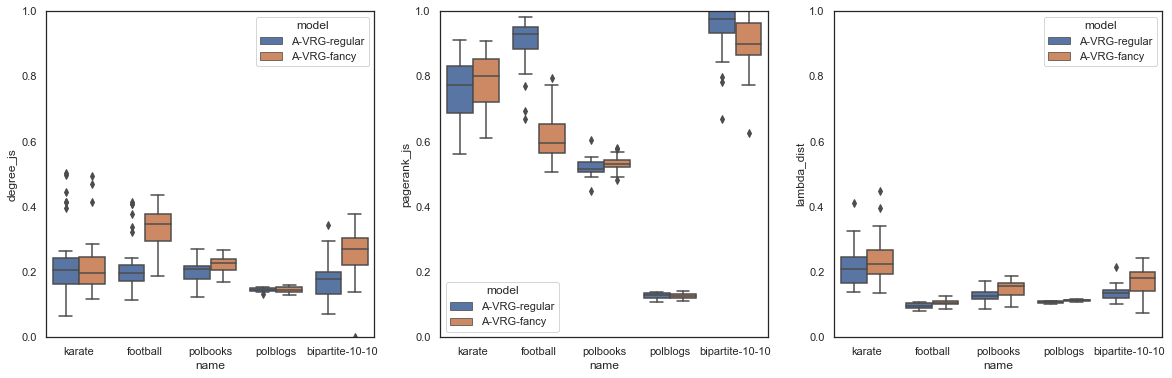

In [11]:
plt.rcParams['figure.figsize'] = [20, 6]
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)

ax1.set_ylim((0, 1))
ax2.set_ylim((0, 1))
ax3.set_ylim((0, 1))

sns.boxplot(x='name', y='degree_js', hue='model', data=overall_df, ax=ax1);
sns.boxplot(x='name', y='pagerank_js', hue='model', data=overall_df, ax=ax2);
sns.boxplot(x='name', y='lambda_dist', hue='model', data=overall_df, ax=ax3);

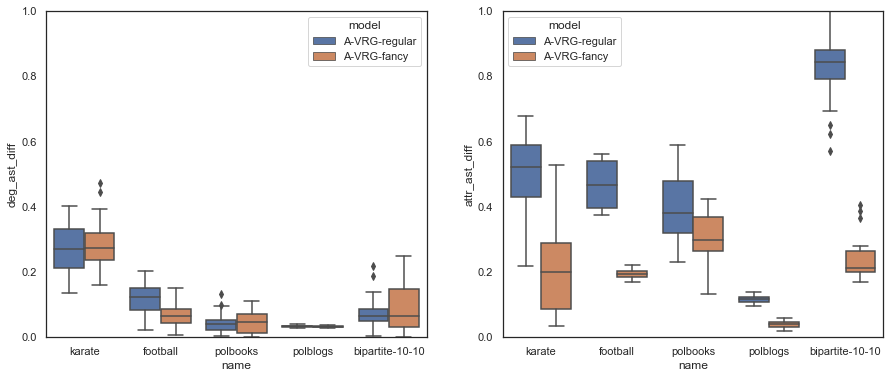

In [12]:
plt.rcParams['figure.figsize'] = [15, 6]
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

ax1.set_ylim((0, 1))
ax2.set_ylim((0, 1))

sns.boxplot(x='name', y='deg_ast_diff', hue='model', data=overall_df, ax=ax1);
sns.boxplot(x='name', y='attr_ast_diff', hue='model', data=overall_df, ax=ax2);

----

In [ ]:
# name = 'karate'; attr_name = 'club'
name = 'polbooks'; attr_name = 'value'
orig_g = get_graph(name)

mixing_dict = nx.attribute_mixing_dict(orig_g, attr_name)

In [ ]:
graphs = load_pickle(f'../VRG/dumps/graphs/polbooks/A-VRG-regular_leiden_5_20.pkl')

In [ ]:
graphs_to_draw = [orig_g] + graphs[: 7]

In [ ]:
grid_plot(graphs_to_draw, attr_name=attr_name, mixing_dict=mixing_dict, graph_name=name)

--- 
Try out football and polblogs

In [ ]:
g = nx.read_pajek('../VRG/input/Epa.net')
g = nx.Graph(g)

In [ ]:
g.remove_edges_from(nx.selfloop_edges(g))
print(nx.info(g))

In [28]:
# make a bipartite graph
for seed in range(10):
    g = nx.bipartite.random_graph(5, 5, 0.6, seed=seed)
    if nx.is_connected(g):
        print('seed', seed)
        break

seed 0


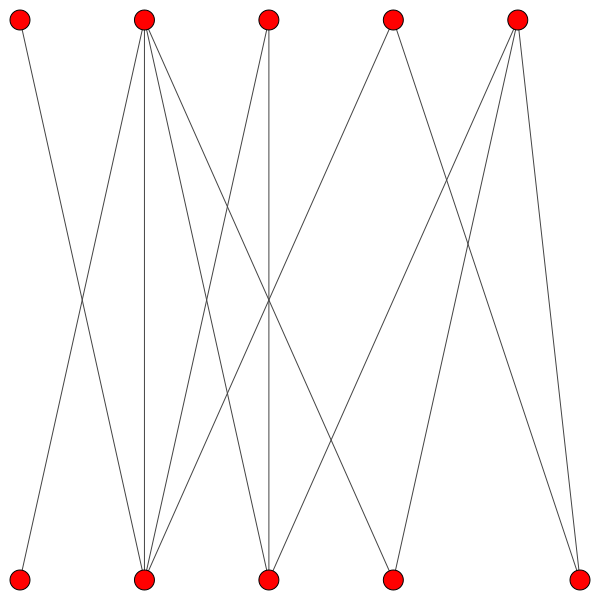

In [50]:
ig_g = ig.Graph.Random_Bipartite(5, 5, 0.6)
ig.plot(ig_g, layout=ig_g.layout_bipartite())

In [46]:
part = ig_g.community_optimal_modularity()
print(part)

Clustering with 10 elements and 2 clusters
[0] 0, 1, 6, 7, 8
[1] 2, 3, 4, 5, 9


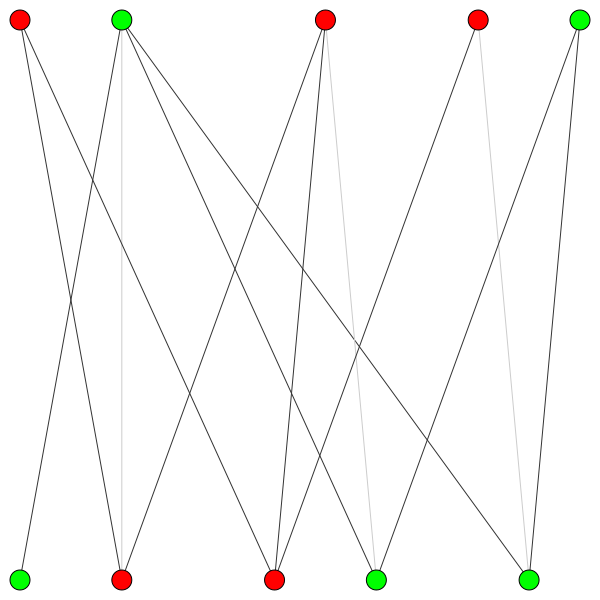

In [47]:
ig.plot(part, layout=ig_g.layout_bipartite())

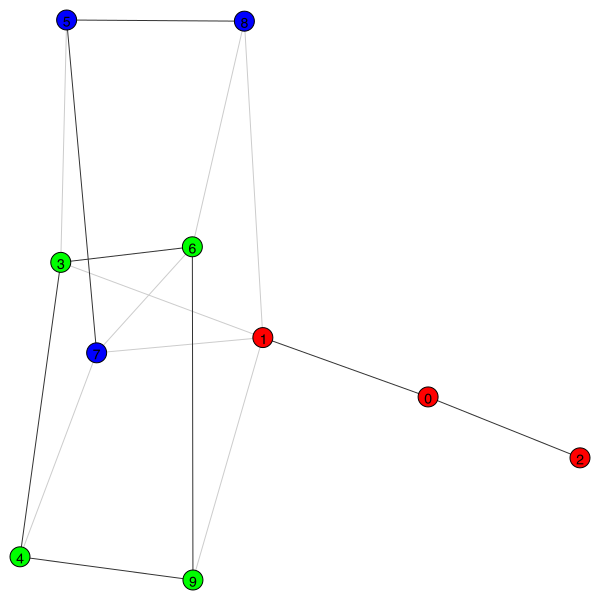

In [32]:
ig.plot(part

### do some things with bipartite graphs

In [ ]:
bip_df = overall_df[overall_df.name.str.contains('bipartite')]

In [ ]:
bip_df.is_bipartite.value_counts()

In [ ]:
nx.algorithms.coloring.